===================================================
### Code developed by: Vinicius Luiz Santos Silva

### Contact: v.santos-silva19@imperial.ac.uk
===================================================

# Import modules

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

# Load compressed data

**In this section we load the data from the compression**

In [3]:
# Mesh size
nl = 10
nc = 10
print('Grid: ', nl, 'x',nc)

Grid:  10 x 10


**Data from compression using PCA (800 variables -> 15 variables)**

In [4]:
import joblib

pca_compress = joblib.load("pca_compress_15.pkl") 
X_train_compressed = np.loadtxt('X_train_pca.csv', delimiter=',') 

X_train_1D = np.loadtxt('X_train_1D.csv', delimiter=',') 
times  = np.loadtxt('times.csv', delimiter=',') 
with open('groups.txt') as f:
    groups = [g.strip() for g in f.readlines()]

# PCA recovered
X_recovered = pca_compress.inverse_transform(X_train_compressed)

**The figure below shows the 15 principal components over time**

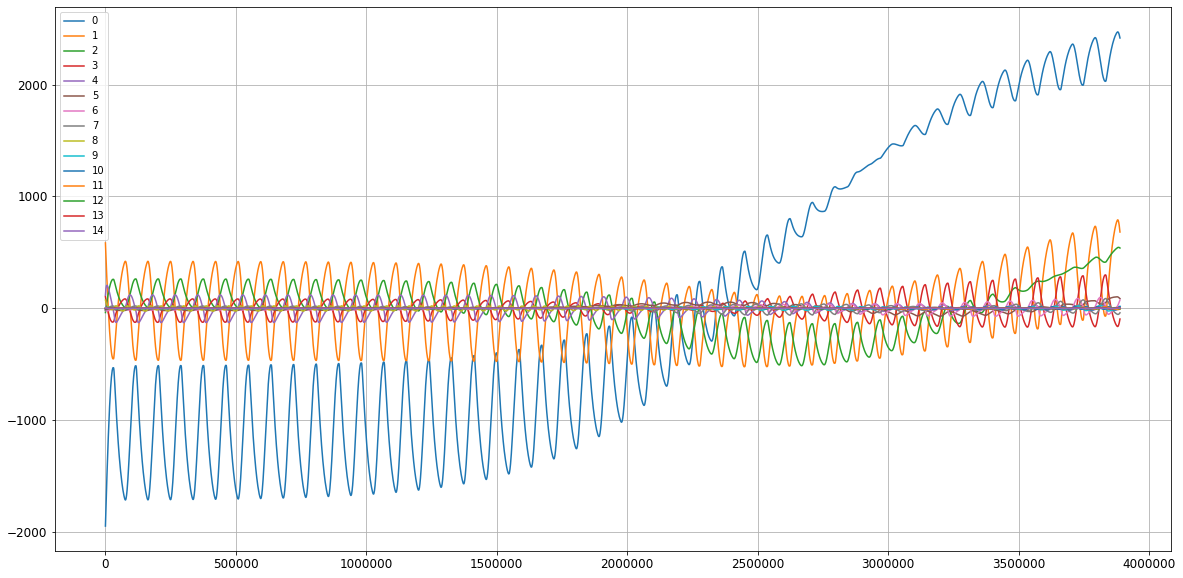

In [5]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(times, X_train_compressed);
ax.grid()
ax.legend(range(15))

**Data from the numerical simulation (real data) at time step 1000**

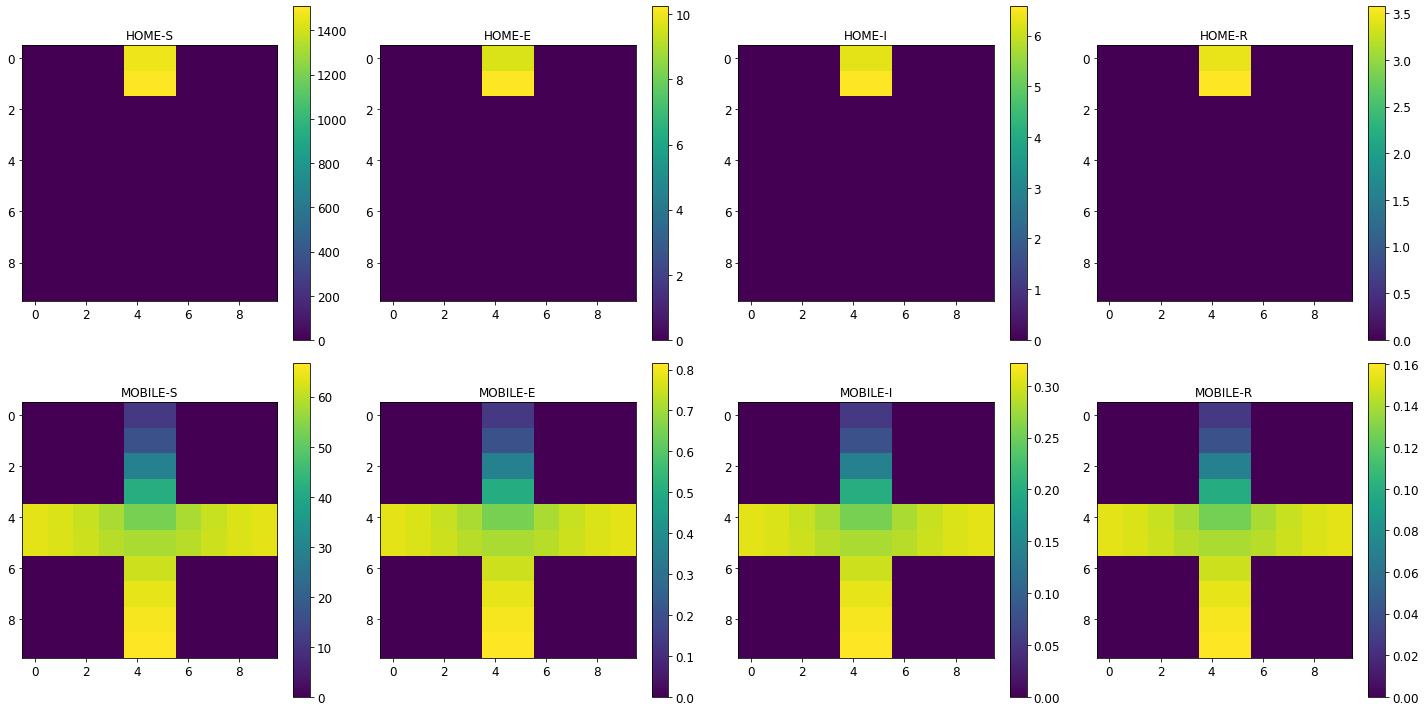

In [6]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_train_1D.reshape(len(times),len(groups),nl,nc)[1000,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)
plt.tight_layout()

**Reconstruction from the PCA at time step 1000**

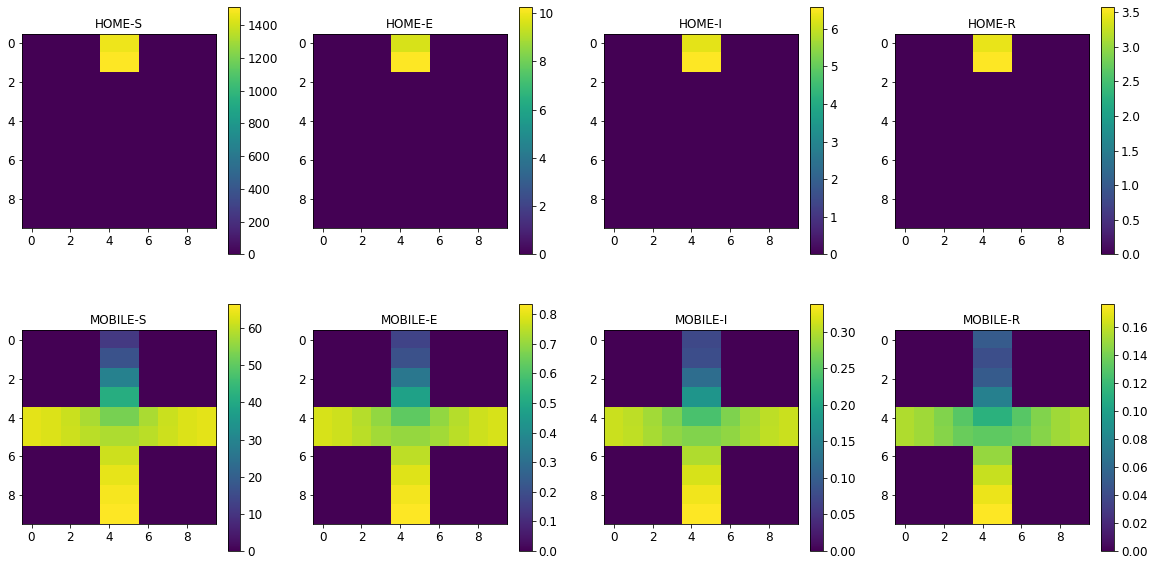

In [7]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_recovered.reshape(len(times),len(groups),nl,nc)[1000,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

**Plot of the eight groups over time for one point in the mesh (reconstruction vs real data)**

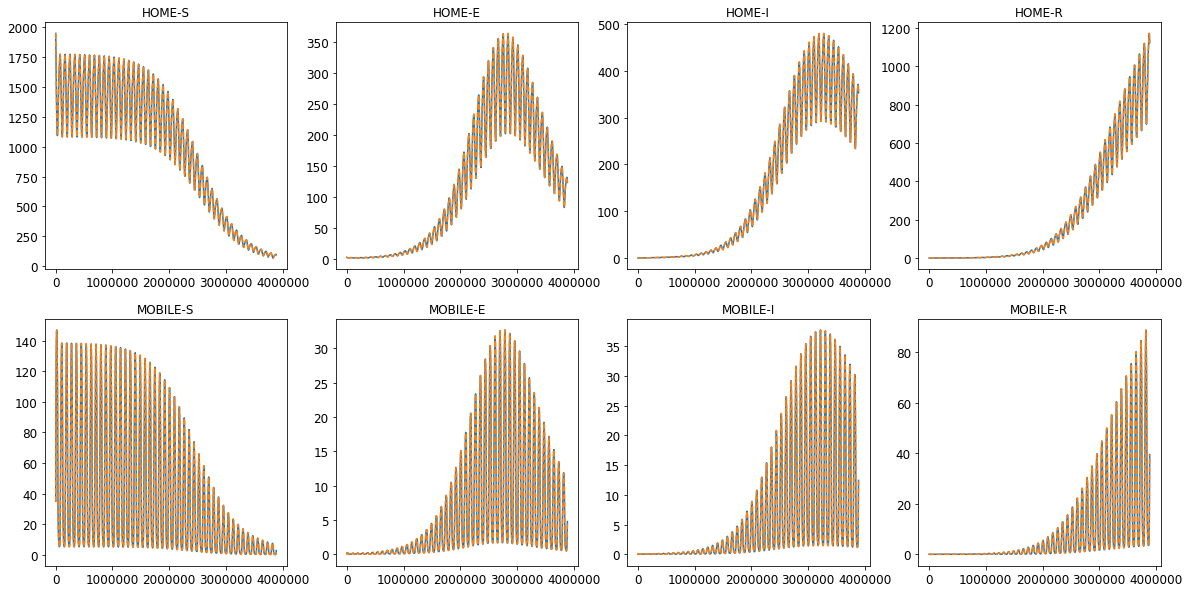

In [7]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_train_1D[:,i*nl*nc+4])
    ax.flatten()[i].plot(times, X_recovered[:,i*nl*nc+4],'--')
    ax.flatten()[i].set_title(group)

## Prepare data

**In this section we prepare the data for the GAN**

In [8]:
codings_size = X_train_compressed.shape[1]
X_train_compressed.shape

(3888, 15)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_compressed)*2 -1
np.allclose(X_train_compressed, scaler.inverse_transform((X_train_scaled+1)/2))

True

In [10]:
def concat_timesteps(X_train, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train) - ntimes*step):
        X_train_concat.append(X_train[i:i+ntimes*step:step])
    return np.array(X_train_concat)

In [11]:
ntimes = 9 # Consecutive times for the GAN
step = 10 # step between times

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )

# Load the GAN

**In this section we load the GAN already trained** 

**The figure below shows five data generated by the GAN. This GAN generates 9 points along one day**

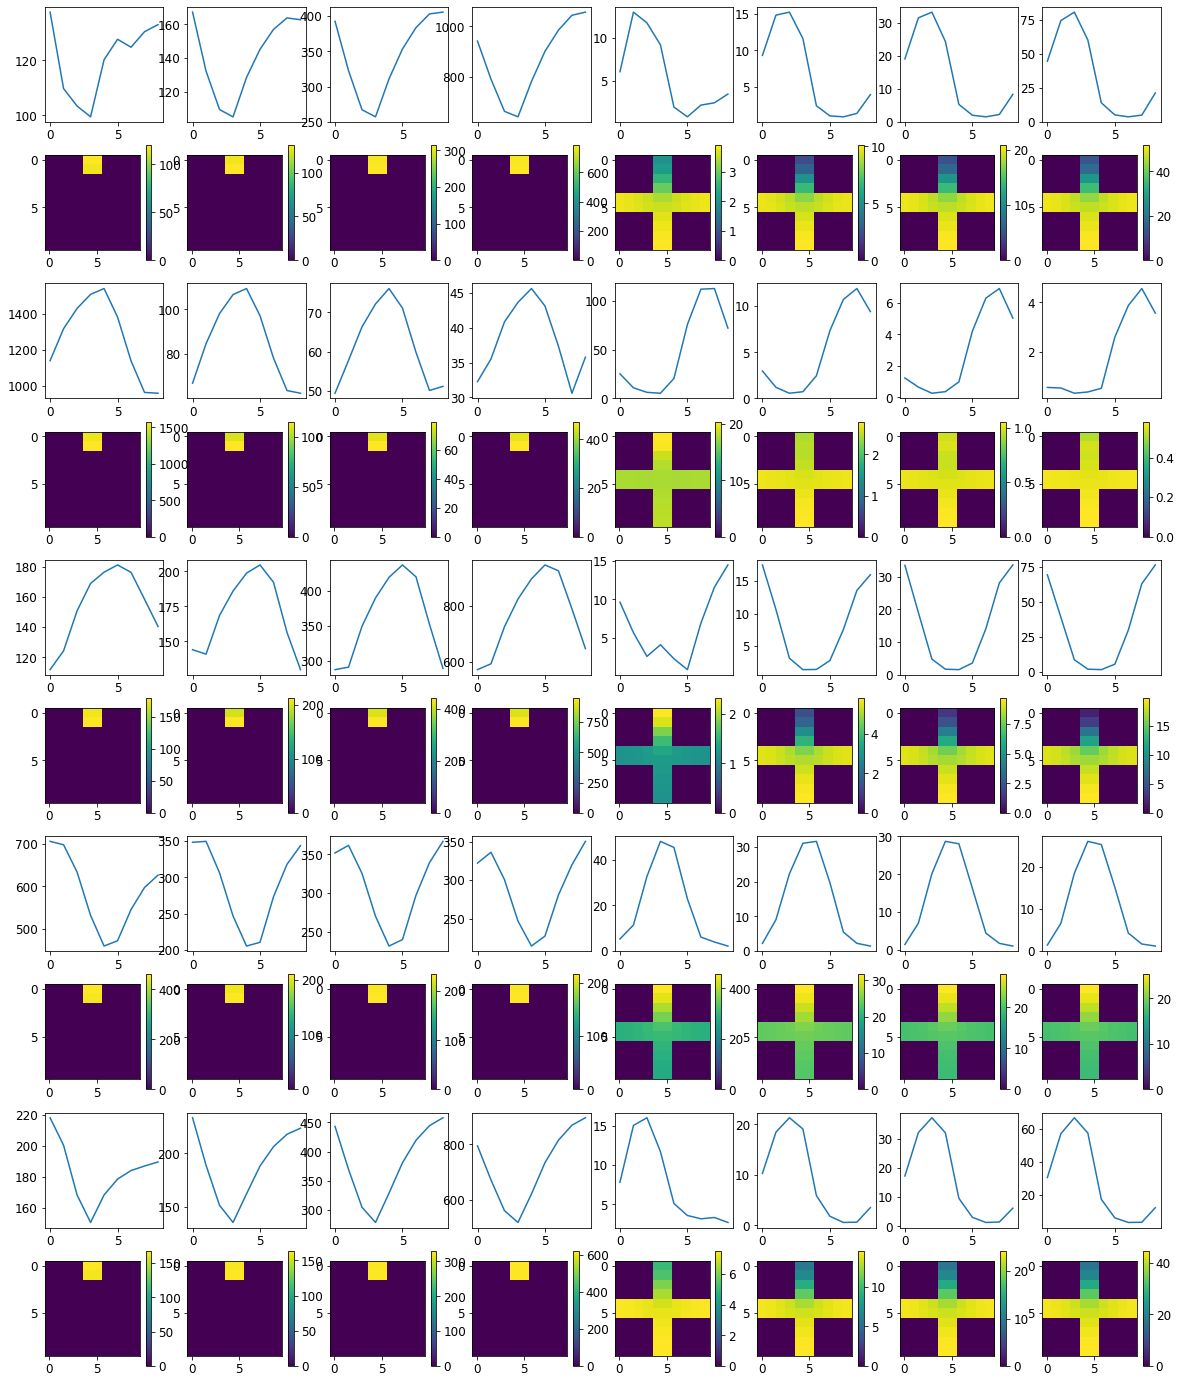

In [12]:
from tensorflow.keras.models import load_model
import joblib
generator, discriminator = load_model('gan-tfex.h5').layers
scaler = joblib.load("scaler.pkl") 

np.random.seed(0)
tf.random.set_seed(0)

npredict = 5
latent_size = 100
noise = tf.random.normal(shape=[npredict, latent_size])
X_generated = scaler.inverse_transform((generator.predict(noise).reshape(npredict*ntimes,codings_size)+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated = X_generated.reshape(npredict, ntimes, len(groups)*nl*nc)
fig, ax = plt.subplots(npredict*2,len(groups), figsize=[20,npredict*5])
for j in range(npredict):
    for i, group in enumerate(groups):
        for k in range(0,10,10): 
            ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
    for i, group in enumerate(groups):
        im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
        fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])

# Predict with the GAN

## Predict one point

**In this section we data assimilated the first 8 points generated by the GAN and predict the 9th**

**We use the singular values as weights for the optimization**

In [13]:
#weight = tf.constant(np.ones(15), dtype=tf.float32)
weight = tf.constant(pca_compress.singular_values_, dtype=tf.float32)
#weight = tf.constant(pca_compress.explained_variance_, dtype=tf.float32)
weight

<tf.Tensor: id=1151, shape=(15,), dtype=float32, numpy=
array([8.0968852e+04, 1.8736416e+04, 1.3673706e+04, 5.5826768e+03,
       3.8501030e+03, 1.8000193e+03, 1.5285522e+03, 1.2805509e+03,
       7.3294604e+02, 4.3526801e+02, 2.9716446e+02, 1.8160262e+02,
       8.7675873e+01, 6.4752045e+01, 5.6145763e+01], dtype=float32)>

In [14]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(1e-2)

def mse_loss(inp, outp, loss_weight):
    inp = tf.reshape(inp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    outp = tf.reshape(outp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    return mse(inp, outp)

In [15]:
#@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [16]:
def optimize_coding(real_coding, loss_weight):
    latent_values = tf.random.normal([len(real_coding), latent_size])  
    latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(1000):
        loss.append(opt_step(latent_values, real_coding, loss_weight).numpy())
        
    plt.plot(loss)
    plt.grid()
    plt.show
        
    return latent_values  #returns the optimized input that generates the desired output

In [17]:
n = 2000
real_coding = X_train_concat_flatten[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

Loss:  0.3277883
<tf.Variable 'Variable:0' shape=(1, 100) dtype=float32, numpy=
array([[ 1.4657146 ,  0.19085237, -0.13002908,  0.30677965, -0.07914612,
        -0.61121356, -2.3765717 ,  1.8313644 ,  0.5400951 , -1.202286  ,
        -0.7513109 , -0.54838973, -2.8391912 ,  2.5522025 , -0.8413737 ,
         1.6846209 , -1.2568367 , -0.88016003,  1.2959806 ,  1.4880857 ,
         0.20474748,  0.47891805, -1.6092246 , -1.6199859 ,  0.11987383,
         0.97071934, -0.3753798 ,  0.07277515,  0.43085837, -0.09062728,
        -1.127862  , -0.5526875 , -1.6255697 , -0.56405926, -0.35492712,
         0.47042945,  0.13957648,  1.8629677 ,  0.46760416,  0.9316561 ,
         0.11509252, -0.14394301,  0.4943446 , -0.18289813, -0.8938889 ,
        -0.11011395, -1.009322  ,  0.20277792,  2.2078235 ,  0.38213333,
        -0.02909521,  0.23697324, -0.13983105,  0.24364692, -0.13143867,
         1.6978933 ,  0.33222604, -0.74282765,  0.5034862 , -0.50594354,
         1.0517328 ,  0.04068863,  1.662449 

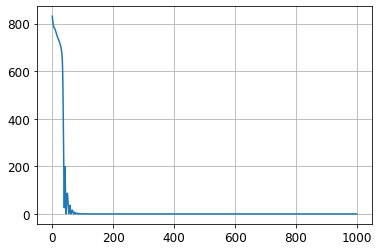

In [18]:
latent_values = optimize_coding(real_coding, weight)
print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:,:], real_coding, weight).numpy())
print(latent_values)

In [19]:
X_generated = scaler.inverse_transform((generator.predict(latent_values).reshape(ntimes,codings_size)+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated = X_generated.reshape(ntimes, len(groups)*nl*nc)

In [20]:
X_real = scaler.inverse_transform((X_train_concat_flatten[n].reshape(ntimes,codings_size)+1)/2)
X_real = pca_compress.inverse_transform(X_real)
X_real = X_real.reshape(ntimes, len(groups)*nl*nc)

**The figure below shows the first 8 points after the data assimilation and the 9th point as a prediction**

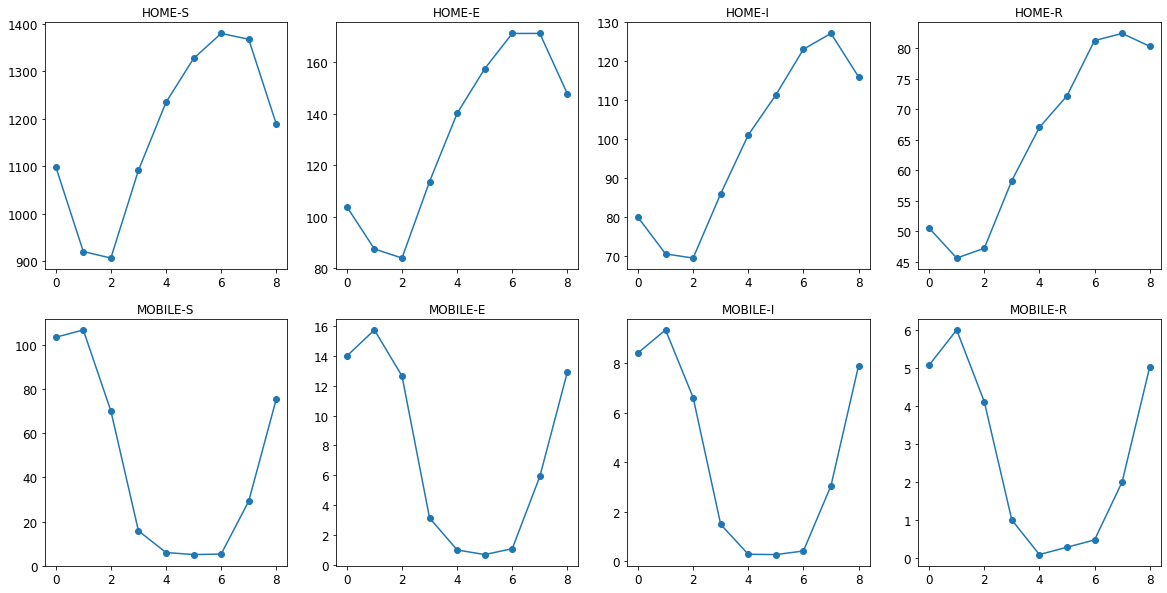

In [21]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:,i*nl*nc+4], '-o')
    ax.flatten()[i].set_title(group)
#plt.savefig('GAN_generateddata.png')

**The figure below shows the real data** 

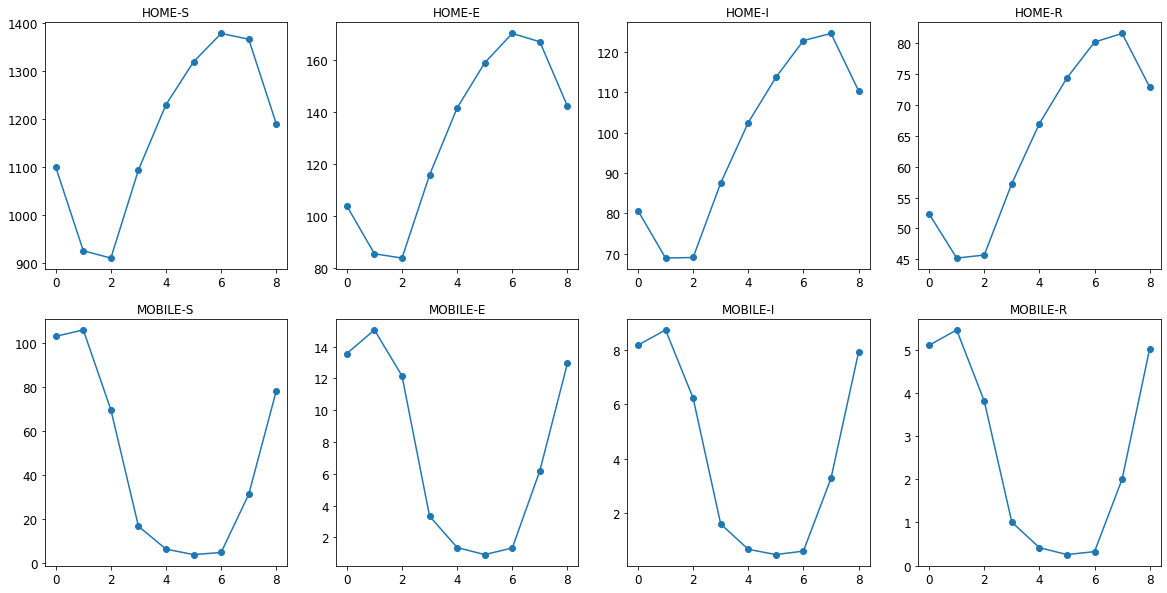

In [22]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_real[:,i*nl*nc+4], '-o')
    ax.flatten()[i].set_title(group)
#plt.savefig('GAN_generateddata.png')

**The figure below shows the predicted data over the mesh**

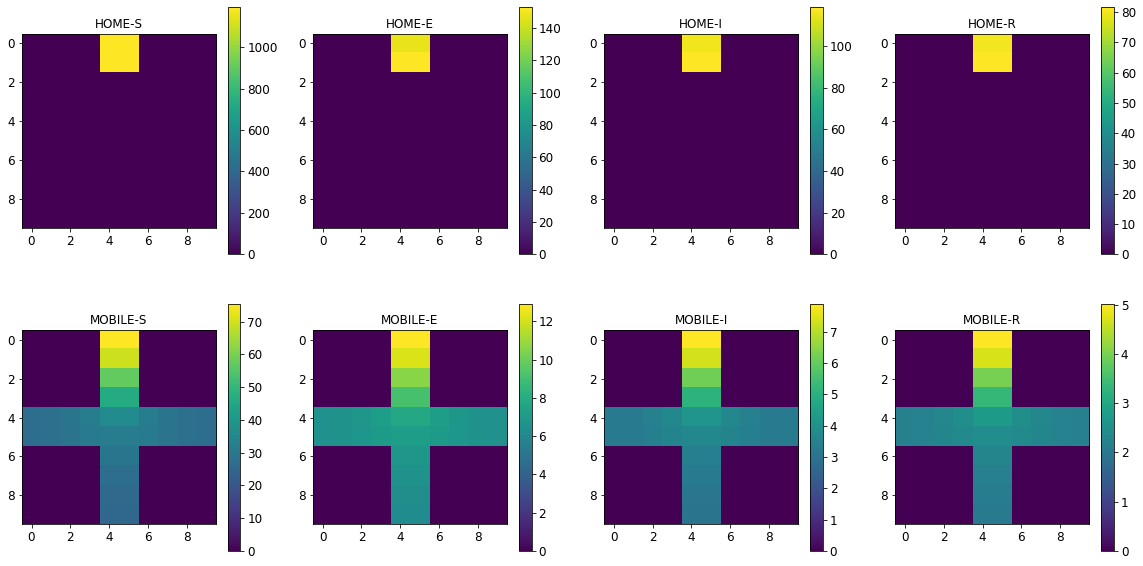

In [23]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_generated.reshape(ntimes,len(groups),nl,nc)[-1,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)
#plt.savefig('GAN_generateddata_mesh.png')

**The figure below show the real data over the mesh**

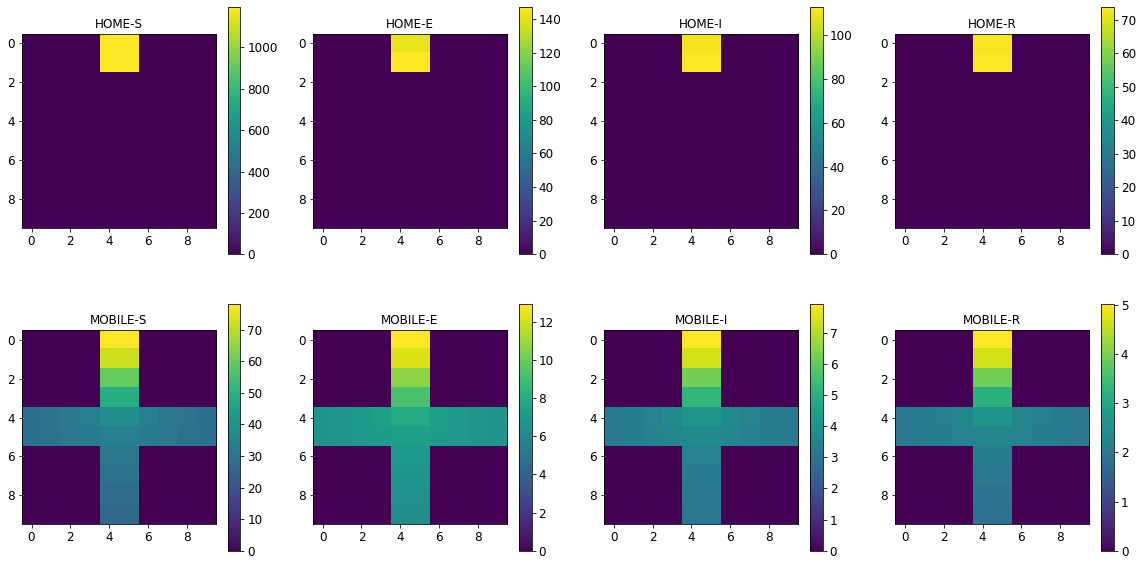

In [24]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_real.reshape(ntimes,len(groups),nl,nc)[-1,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)
#plt.savefig('GAN_generateddata_mesh.png')

**The figure below shows the difference between the predicted and real data**

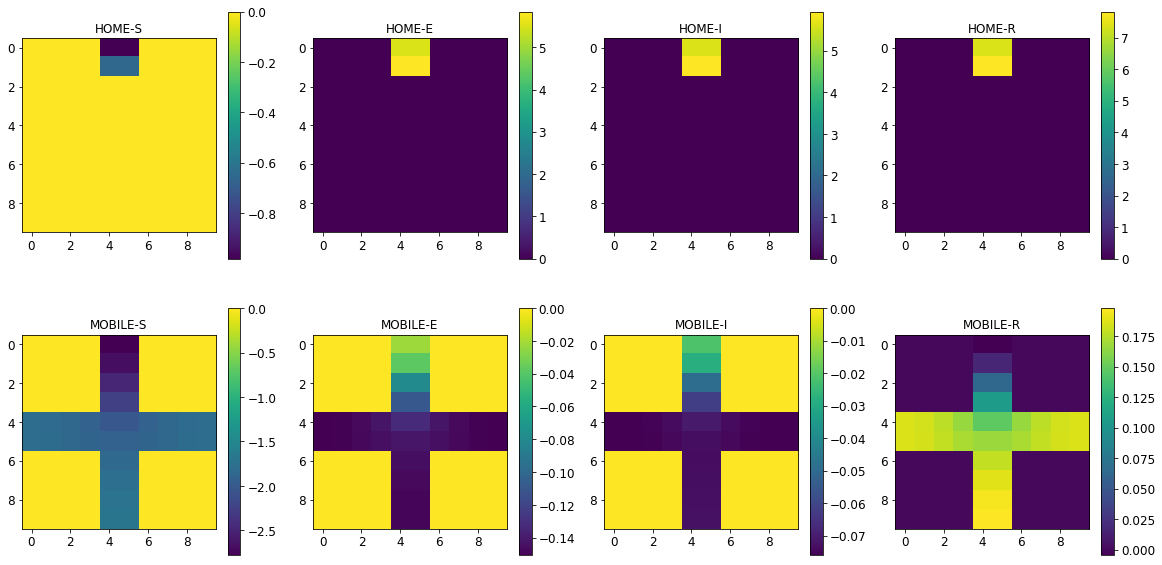

In [25]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_generated.reshape(ntimes,len(groups),nl,nc)[-1,i,:,:]
                                -X_real.reshape(ntimes,len(groups),nl,nc)[-1,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)
#plt.savefig('GAN_generateddata_mesh.png')

## Predict multiple points

**In this section we predict multiple points. We use the last predictions as the points to data assimilate in the next prediction** 

In [26]:
def optimize_coding(latent_values, real_coding, loss_weight, epochs=1000):
    
    for epoch in range(epochs):
        opt_step(latent_values, real_coding, loss_weight)
        
    return latent_values  #returns the optimized input that generates the desired output

### Start point = time step 2000

In [26]:
np.random.seed(0)
tf.random.set_seed(0)

n = 2000
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_size])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(100): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, weight, epochs=1000)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

In [27]:
X_generated = scaler.inverse_transform((X_predict+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated = X_generated.reshape(len(X_predict), len(groups)*nl*nc)
X_generated[X_generated<0] = 0 

**The figure below shows the prediction for 3 days in one point of the mesh** 

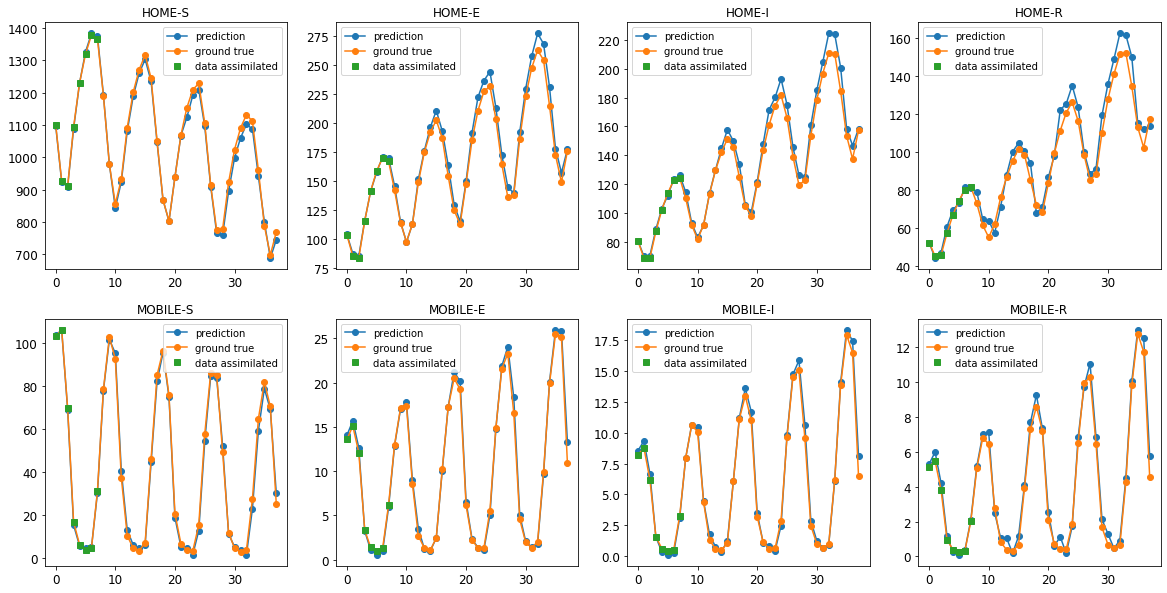

In [28]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:8+30,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8+30)*step:step,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+4], 's')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground true', 'data assimilated'])
#plt.savefig('GAN_generateddata.png')

**The figure below shows the prediction for 3 days in another point of the mesh** 

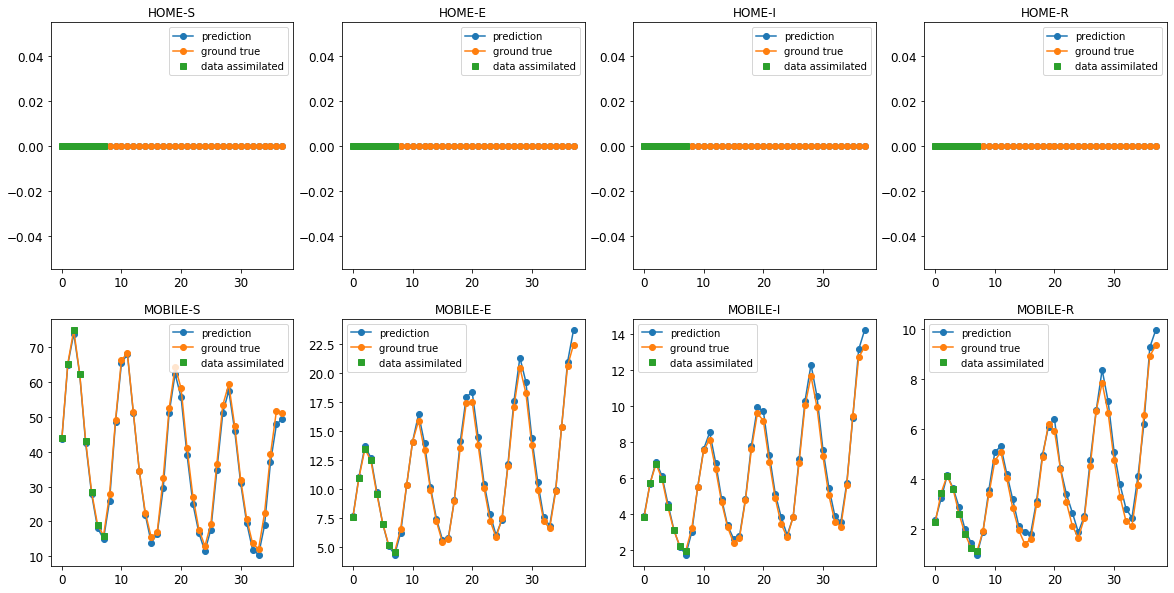

In [29]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:8+30,i*nl*nc+84], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8+30)*step:step,i*nl*nc+84], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+84], 's')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground true', 'data assimilated'])
#plt.savefig('GAN_generateddata.png')

**The figure below shows the prediction for 11 days in one point of the mesh** 

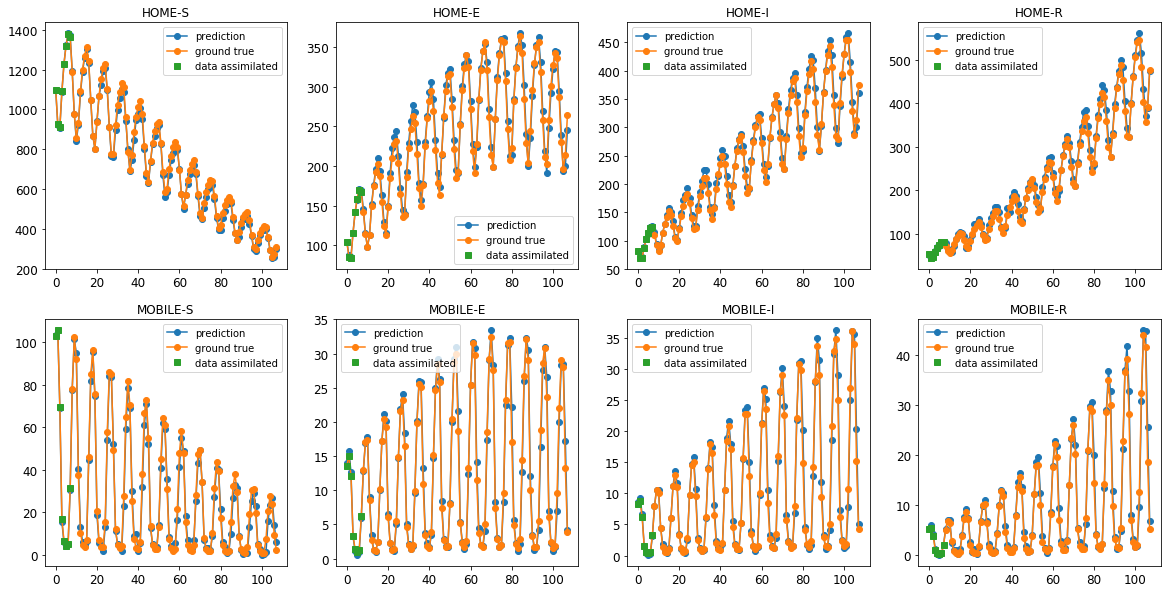

In [30]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:8+100,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8+100)*step:step,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+4], 's')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground true', 'data assimilated'])
#plt.savefig('GAN_generateddata.png')

**The figure below shows the prediction for 11 days in another point of the mesh** 

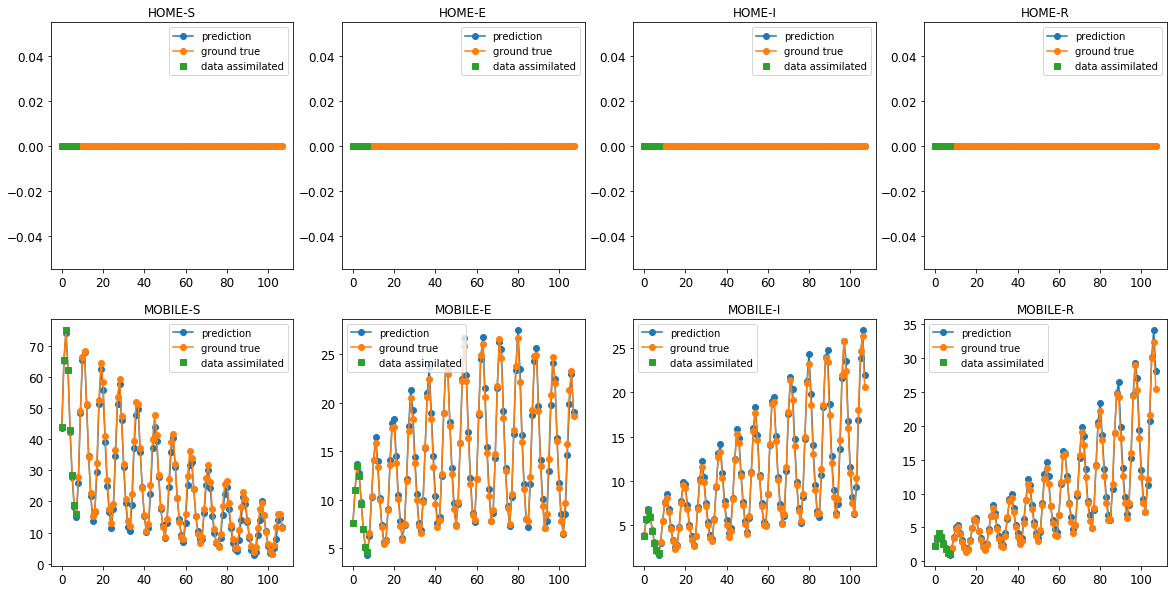

In [31]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:8+100,i*nl*nc+84], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8+100)*step:step,i*nl*nc+84], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+84], 's')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground true', 'data assimilated'])
#plt.savefig('GAN_generateddata.png')

### Start point = time step 1000

In [32]:
np.random.seed(0)
tf.random.set_seed(0)

n = 1000
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_size])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(100): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, weight, epochs=1000)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

In [33]:
X_generated = scaler.inverse_transform((X_predict+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated = X_generated.reshape(len(X_predict), len(groups)*nl*nc)
X_generated[X_generated<0] = 0 

**The figure below shows the prediction for 3 days in one point of the mesh** 

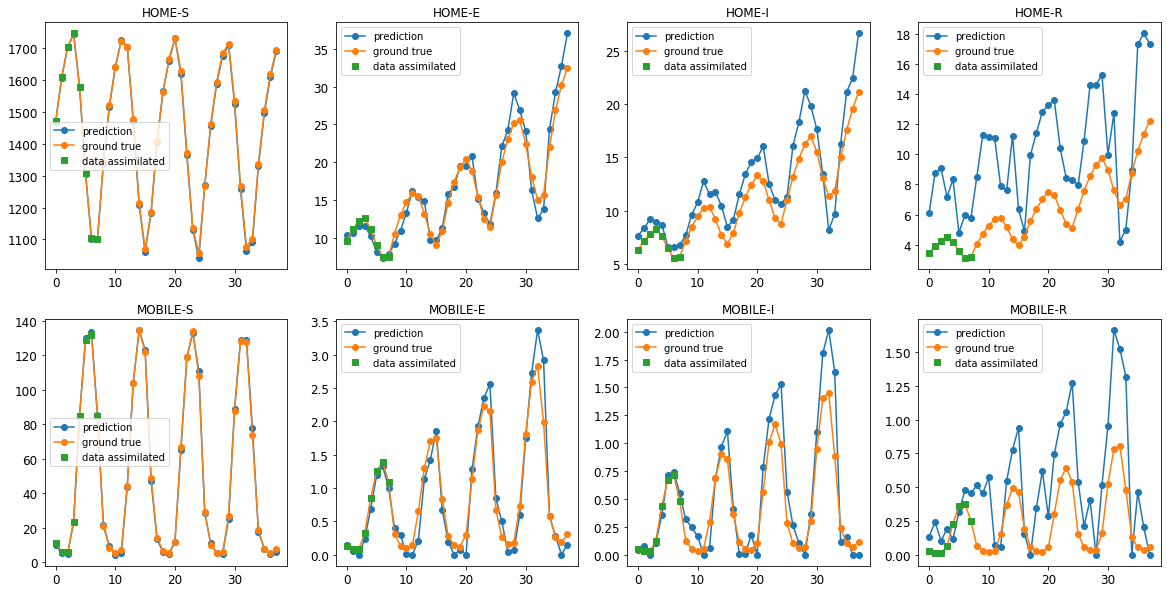

In [34]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:8+30,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8+30)*step:step,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+4], 's')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground true', 'data assimilated'])
#plt.savefig('GAN_generateddata.png')

**The figure below shows the prediction for 3 days in another point of the mesh** 

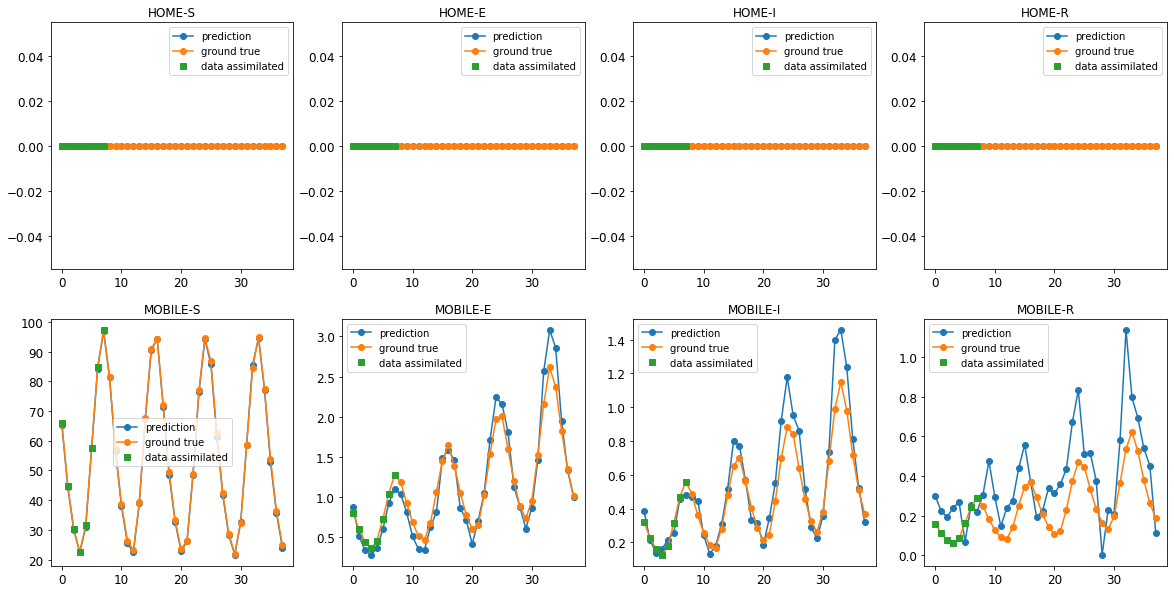

In [35]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:8+30,i*nl*nc+84], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8+30)*step:step,i*nl*nc+84], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+84], 's')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground true', 'data assimilated'])
#plt.savefig('GAN_generateddata.png')

**The figure below shows the prediction for 11 days in one point of the mesh** 

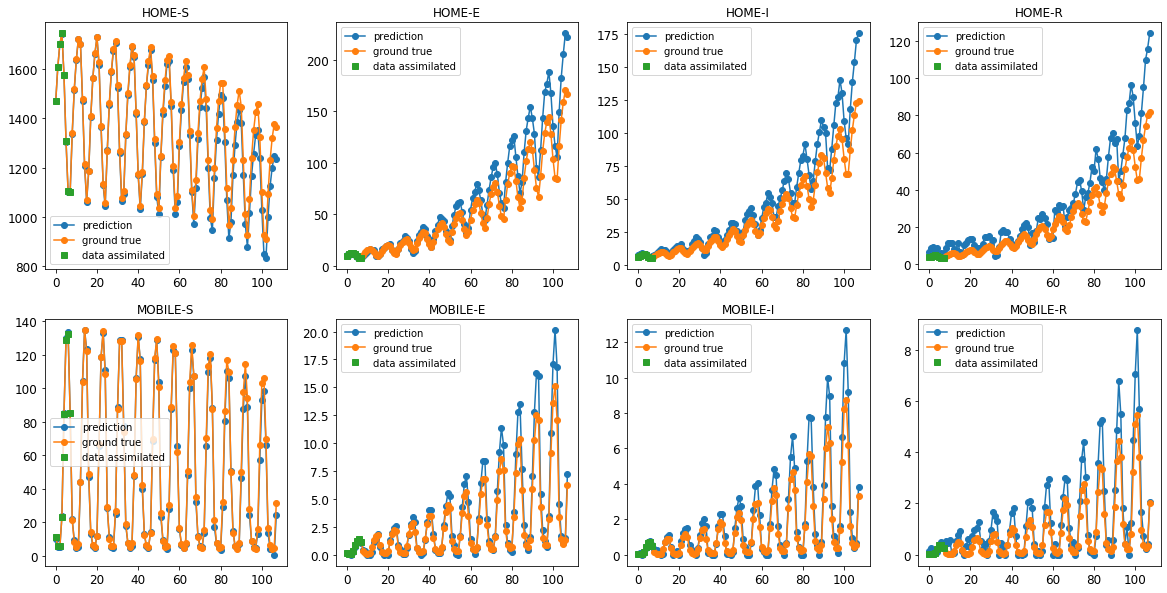

In [36]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:8+100,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8+100)*step:step,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+4], 's')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground true', 'data assimilated'])
#plt.savefig('GAN_generateddata.png')

**The figure below shows the prediction for 11 days in another point of the mesh** 

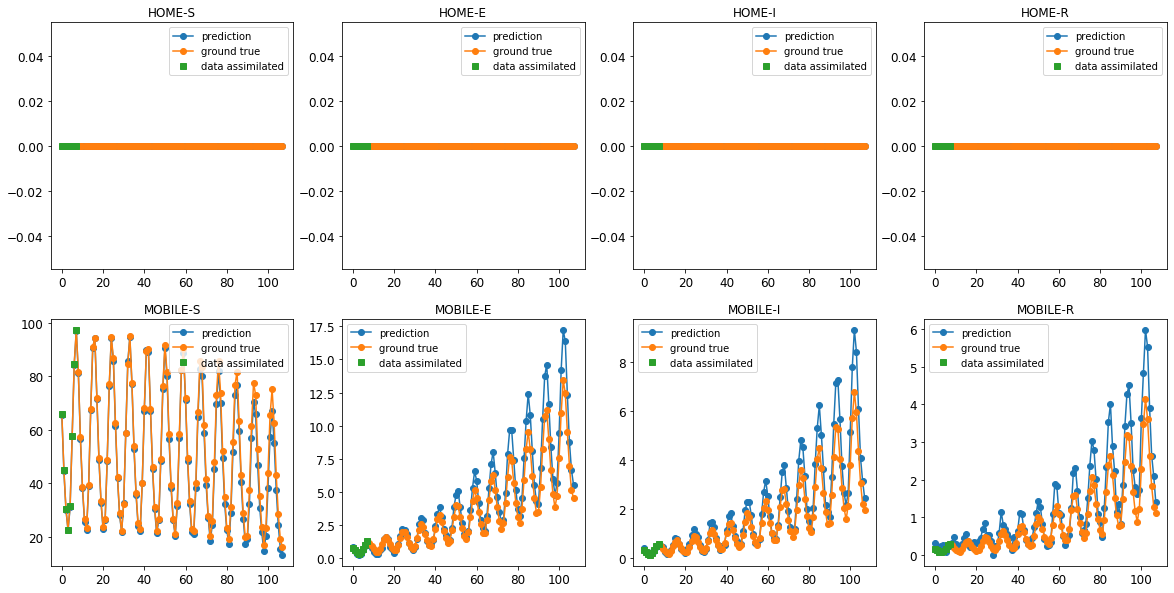

In [37]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:8+100,i*nl*nc+84], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8+100)*step:step,i*nl*nc+84], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+84], 's')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground true', 'data assimilated'])
#plt.savefig('GAN_generateddata.png')

### Start point = time step 3000

In [38]:
np.random.seed(0)
tf.random.set_seed(0)

n = 3000
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_size])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(100): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, weight, epochs=1000)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

In [39]:
X_generated = scaler.inverse_transform((X_predict+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated = X_generated.reshape(len(X_predict), len(groups)*nl*nc)
X_generated[X_generated<0] = 0 

**The figure below shows the prediction for 3 days in one point of the mesh** 

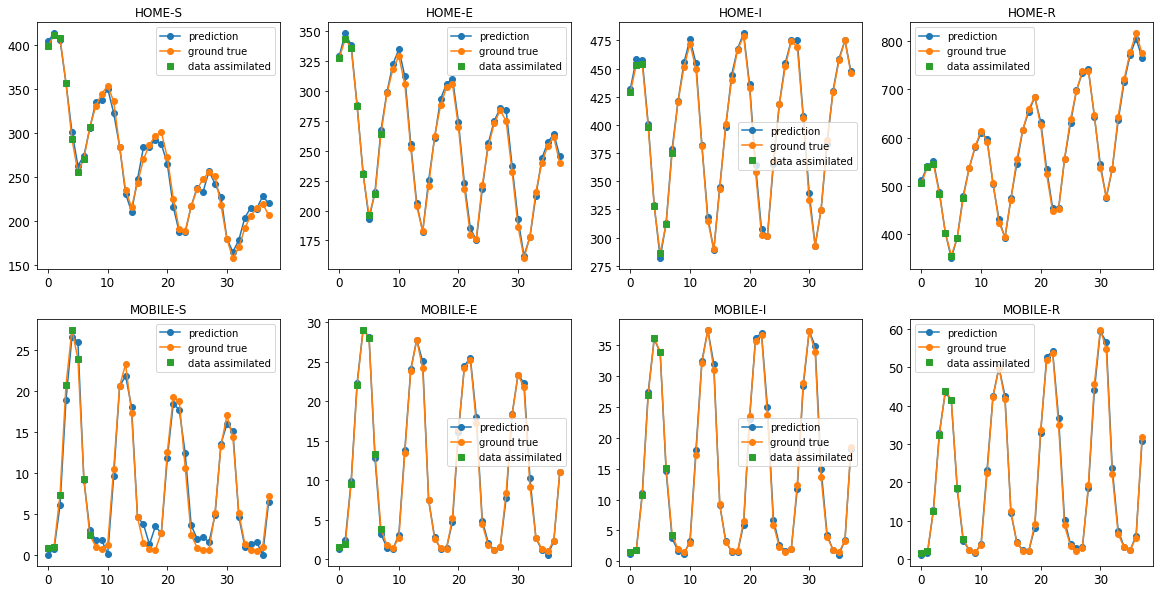

In [40]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:8+30,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8+30)*step:step,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+4], 's')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground true', 'data assimilated'])
#plt.savefig('GAN_generateddata.png')

**The figure below shows the prediction for 3 days in another point of the mesh** 

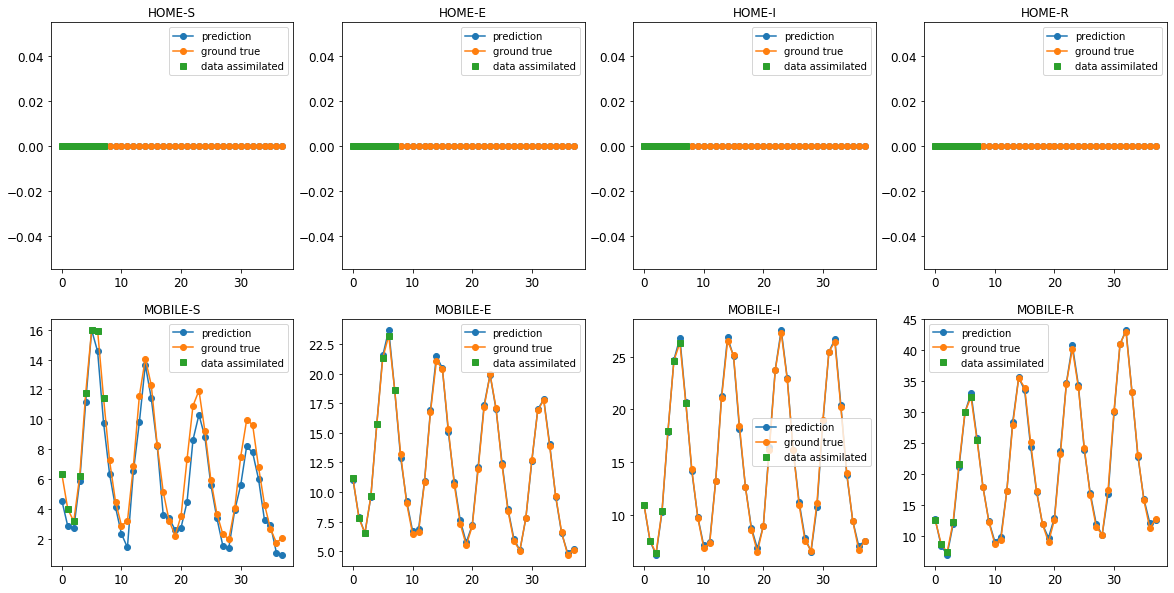

In [41]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:8+30,i*nl*nc+84], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8+30)*step:step,i*nl*nc+84], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+84], 's')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground true', 'data assimilated'])
#plt.savefig('GAN_generateddata.png')

**The figure below shows the prediction for 11 days in one point of the mesh** 

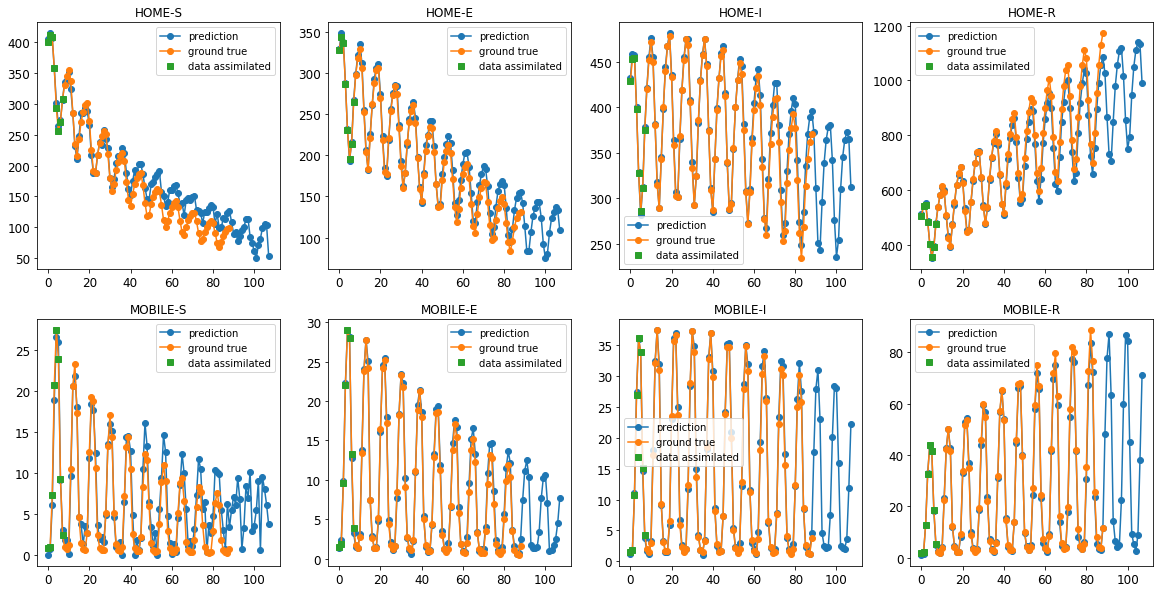

In [42]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:8+100,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8+100)*step:step,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+4], 's')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground true', 'data assimilated'])
#plt.savefig('GAN_generateddata.png')

**The figure below shows the prediction for 11 days in another point of the mesh** 

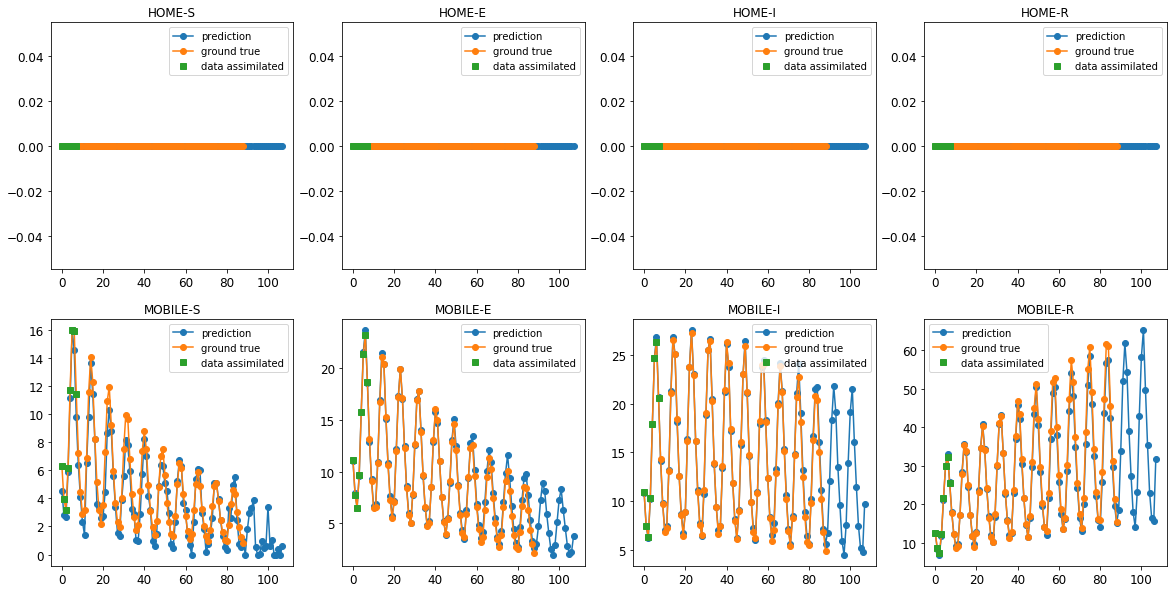

In [43]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:8+100,i*nl*nc+84], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8+100)*step:step,i*nl*nc+84], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+84], 's')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground true', 'data assimilated'])
#plt.savefig('GAN_generateddata.png')

## Predict the whole simulation

### Start point = time step 10

In [27]:
np.random.seed(0)
tf.random.set_seed(0)

n = 10
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_size])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(400): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, weight, epochs=1000)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

In [28]:
X_generated = scaler.inverse_transform((X_predict+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated = X_generated.reshape(len(X_predict), len(groups)*nl*nc)
X_generated[X_generated<0] = 0 
np.save('X_generatedall.npy',X_generated)

In [29]:
n = 10
X_generatedall = np.load('X_generatedall.npy')

**The figure below shows the prediction for one point of the mesh** 

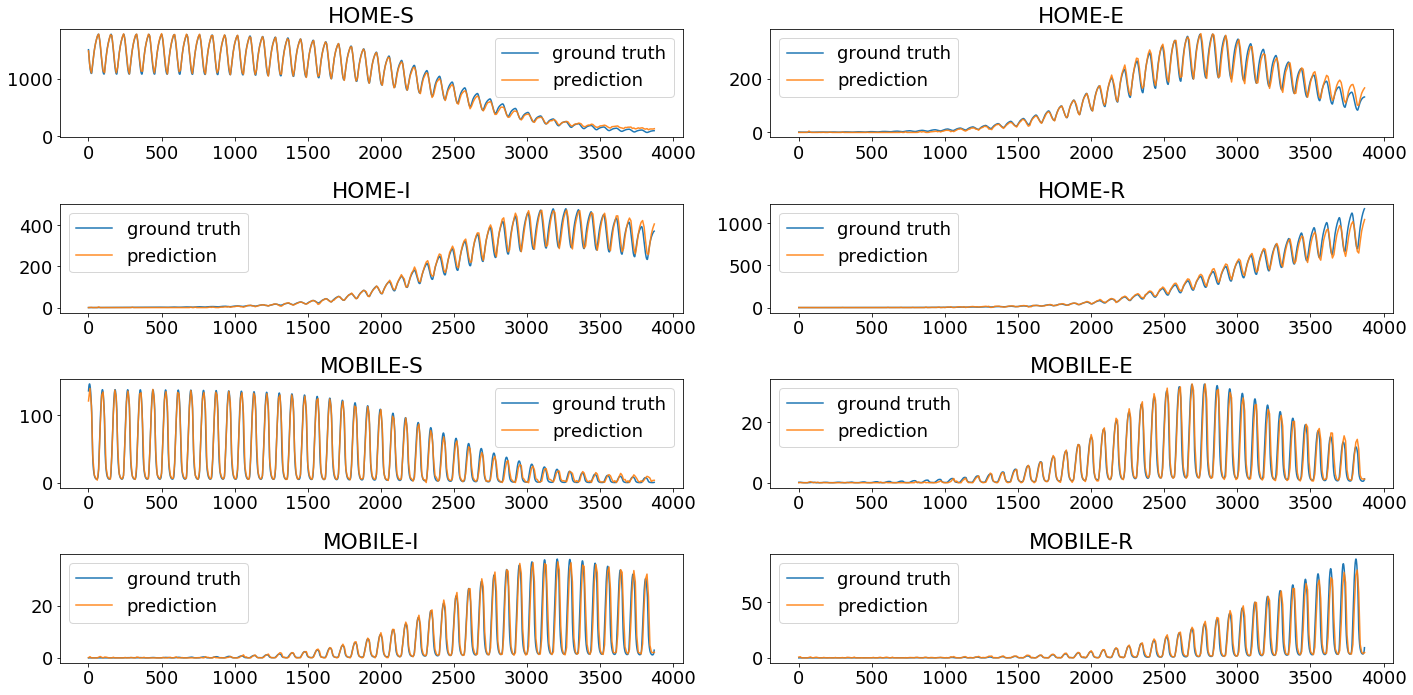

In [30]:
mpl.rcParams.update({'font.size': 18})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18)
fig, ax = plt.subplots(4,2, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train_1D[n:(388)*step,i*nl*nc+4], '-')
    ax.flatten()[i].plot(np.arange(388)*step, X_generatedall[:388,i*nl*nc+4], '-', alpha=0.9)
    #ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+4], '')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['ground truth', 'prediction', 'data assimilated'])
plt.tight_layout()
plt.savefig('GAN_0-end_p4.png')

**The figure below shows the prediction another point of the mesh** 

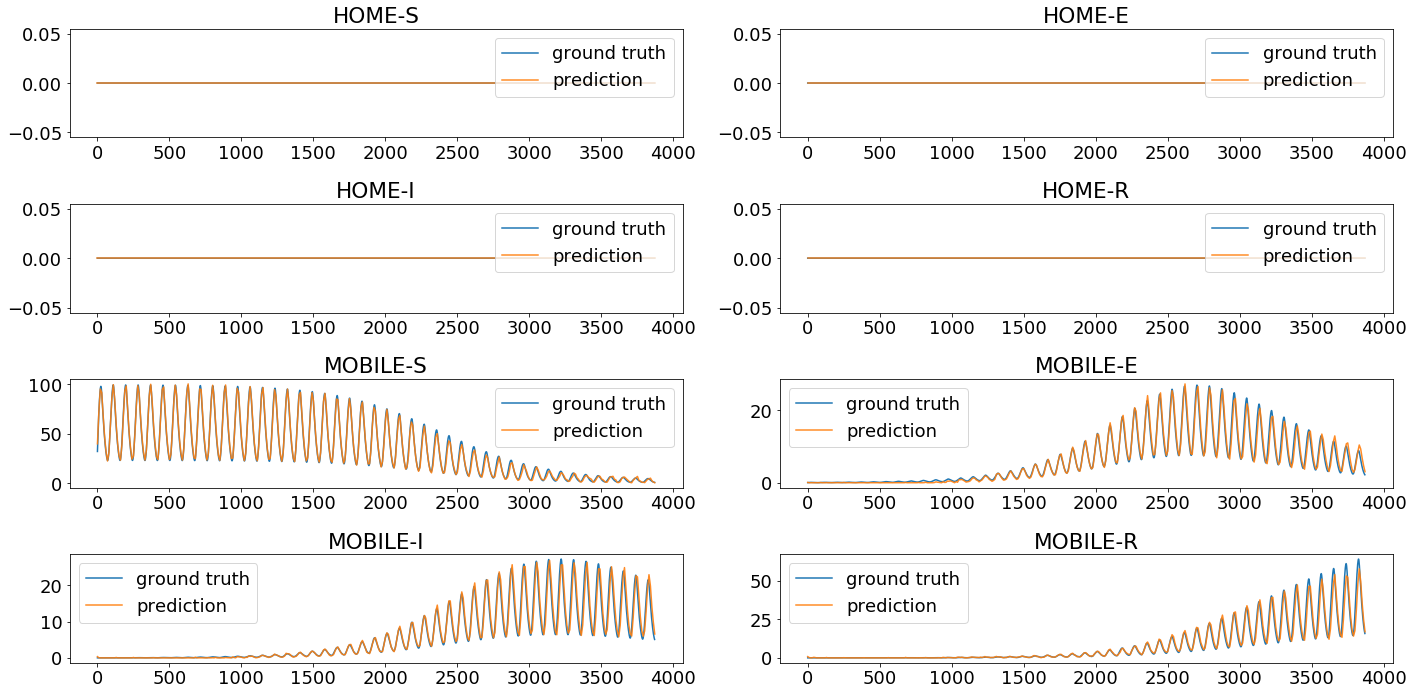

In [31]:
mpl.rcParams.update({'font.size': 18})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18)
fig, ax = plt.subplots(4,2, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train_1D[n:(388)*step,i*nl*nc+84], '-')
    ax.flatten()[i].plot(np.arange(388)*step, X_generatedall[:388,i*nl*nc+84], '-', alpha=0.9)
    #ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+4], '')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['ground truth', 'prediction', 'data assimilated'])
plt.tight_layout()
plt.savefig('GAN_0-end_p84.png')

**The figure below shows the prediction at time step 2000 for the whole mesh** 

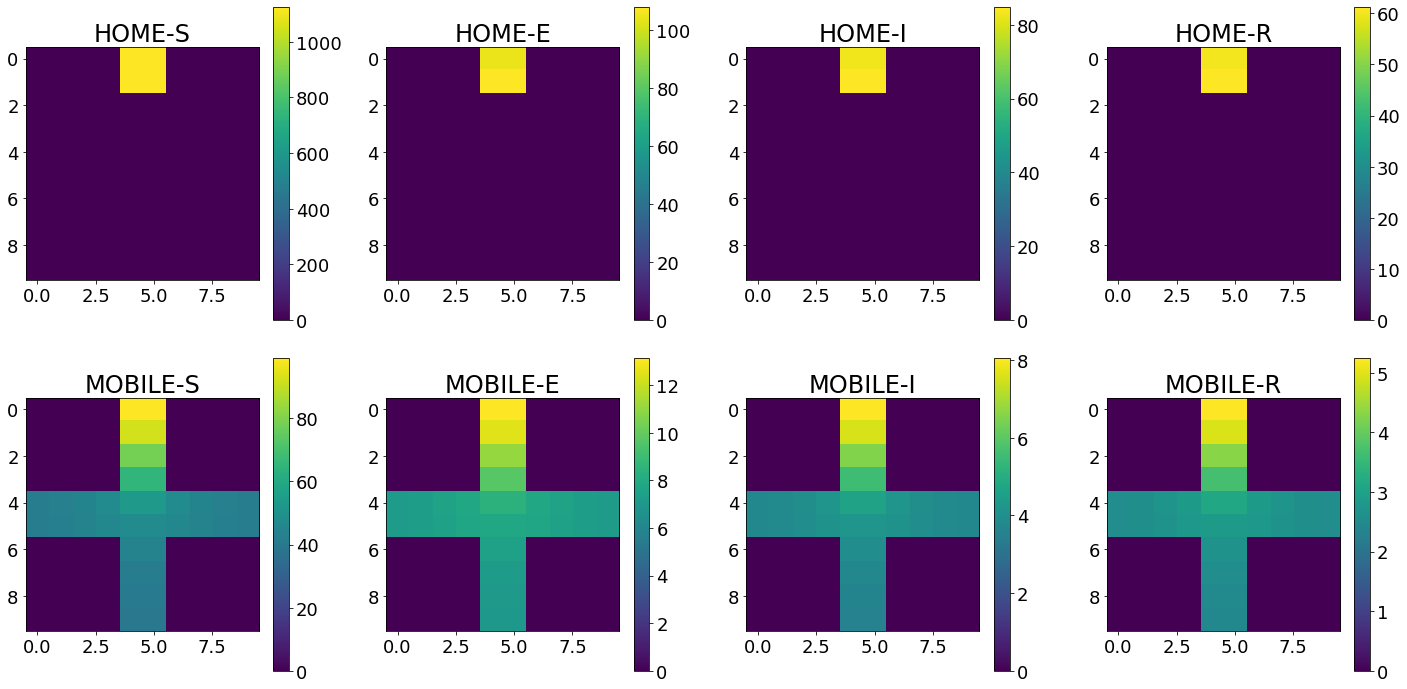

In [33]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18) 
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_generatedall[199,:].reshape(1,len(groups),nl,nc)[-1,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)
plt.tight_layout()
plt.savefig('meshprgan_2000.png')

**The figure below shows the absolute difference between the prediction and real data at time step 2000 for the whole mesh** 

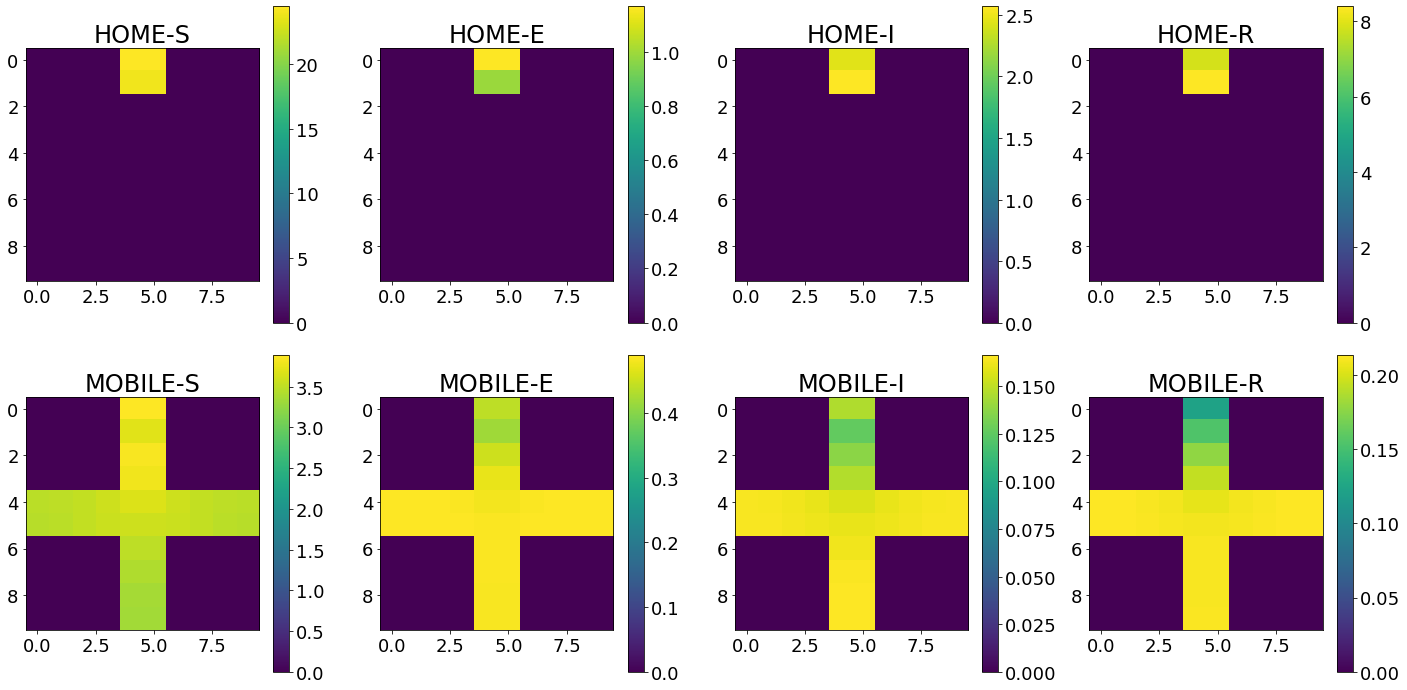

In [32]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18)
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(abs(X_generatedall[199,:].reshape(1,len(groups),nl,nc)[-1,i,:,:]
                                -X_train_1D[2000,:].reshape(1,len(groups),nl,nc)[-1,i,:,:]))
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)
plt.tight_layout()
plt.savefig('meshprgan_2000_diff.png')

### Start point = time step 2000

In [34]:
np.random.seed(0)
tf.random.set_seed(0)

n = 2000
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_size])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(400): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, weight, epochs=1000)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

In [35]:
X_generated = scaler.inverse_transform((X_predict+1)/2)
X_generated = pca_compress.inverse_transform(X_generated)
X_generated = X_generated.reshape(len(X_predict), len(groups)*nl*nc)
X_generated[X_generated<0] = 0 
np.save('X_generated2000.npy',X_generated)

In [36]:
n = 2000
X_generated2000 = np.load('X_generated2000.npy')

**The figure below shows the prediction for one point of the mesh** 

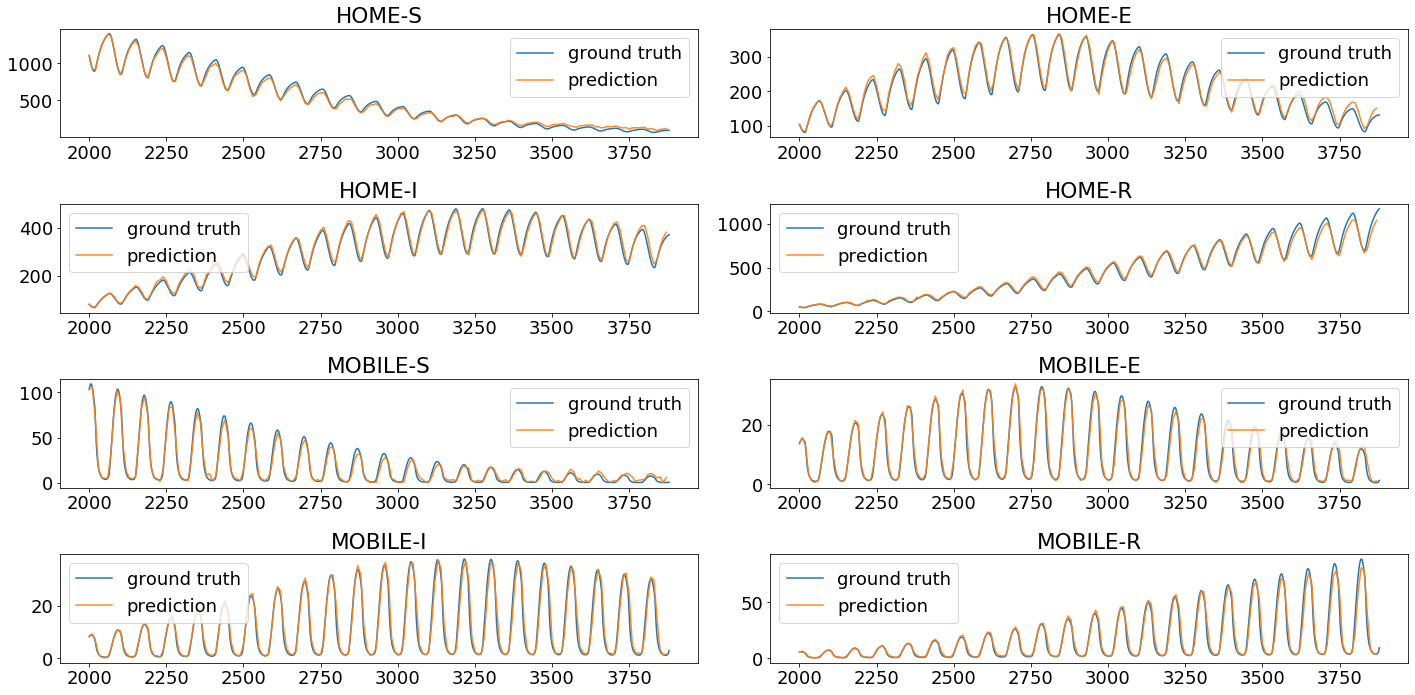

In [37]:
mpl.rcParams.update({'font.size': 18})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18)
fig, ax = plt.subplots(4,2, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(np.arange(188*step)+2000, X_train_1D[n:(388)*step,i*nl*nc+4], '-')
    ax.flatten()[i].plot(np.arange(188)*step + 2000, X_generated[:188,i*nl*nc+4], '-', alpha=0.9)
    #ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+4], '')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['ground truth', 'prediction', 'data assimilated'])
plt.tight_layout()
plt.savefig('GAN_2000-end_p4.png')

**The figure below shows the prediction another point of the mesh** 

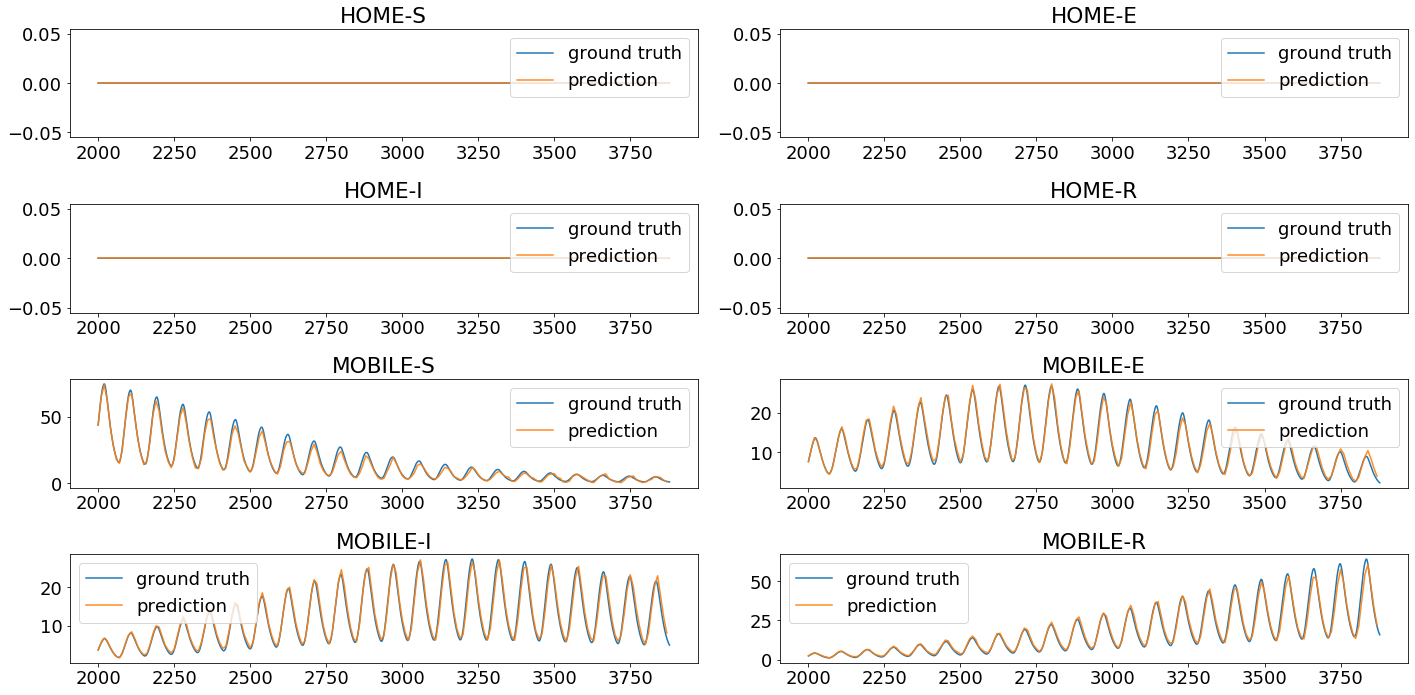

In [38]:
mpl.rcParams.update({'font.size': 18})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18)
fig, ax = plt.subplots(4,2, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(np.arange(188*step)+2000, X_train_1D[n:(388)*step,i*nl*nc+84], '-')
    ax.flatten()[i].plot(np.arange(188)*step + 2000, X_generated[:188,i*nl*nc+84], '-', alpha=0.9)
    #ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+4], '')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['ground truth', 'prediction', 'data assimilated'])
plt.tight_layout()
plt.savefig('GAN_2000-end_p84.png')